In [1]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = "./figures/preprocessing/"
sc.set_figure_params(dpi=80, dpi_save=300, frameon=True, vector_friendly=True, figsize=[8,5])

In [2]:
adata = ad.read_h5ad("anndata_with_unrolled.h5ad")
adata

AnnData object with n_obs × n_vars = 120694 × 499
    obs: 'x', 'y', 'cluster', 'n_transcripts', 'density', 'elongation', 'area', 'avg_confidence', 'cell_shape'
    uns: 'points'
    obsm: 'spatial', 'unrolled'

/home/max/QnapSync/Documents/Postdoc/Lab/Projects/Merscope/Slide01_Doudenum/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


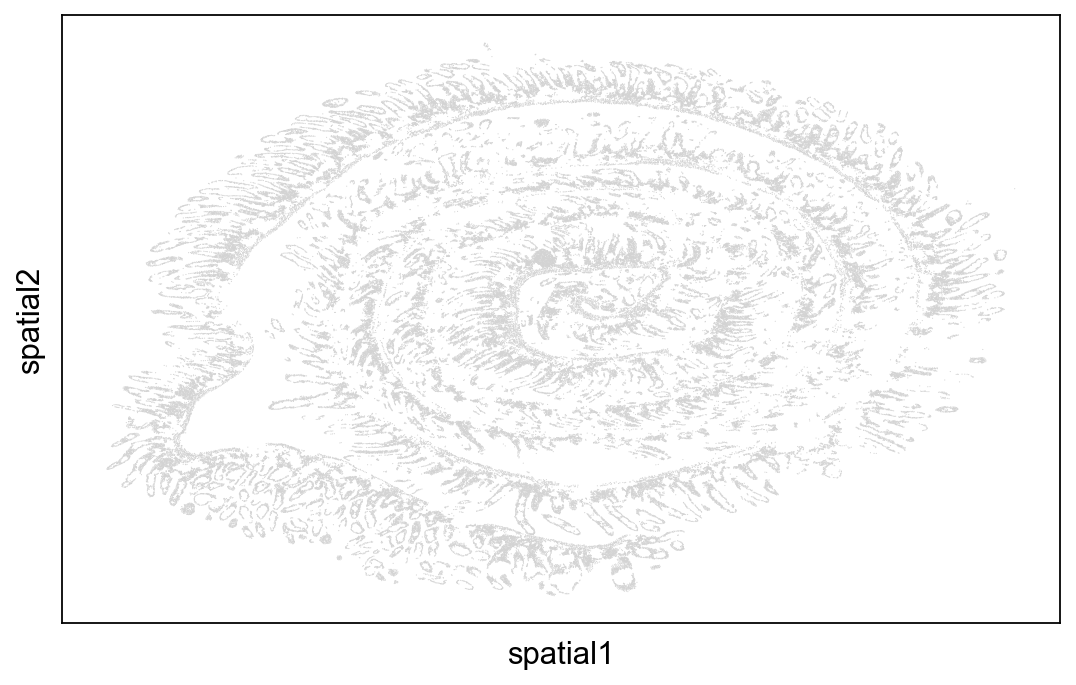

In [3]:
sc.pl.embedding(adata, basis="spatial", save='_no_color.png')

## QC

In this section, let's perform some QC metrics. Let's start by removing cells that have less than 5 genes and genes that are expressed in less that 3 cells/

In [4]:
adata.var_names_make_unique()
print("data shape:", adata.shape)
sc.pp.filter_cells(adata, min_genes=5)
sc.pp.filter_genes(adata, min_cells=3)

data shape: (120694, 499)
filtered out 6818 cells that have less than 5 genes expressed


In [5]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
adata

AnnData object with n_obs × n_vars = 113876 × 499
    obs: 'x', 'y', 'cluster', 'n_transcripts', 'density', 'elongation', 'area', 'avg_confidence', 'cell_shape', 'n_genes', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'points'
    obsm: 'spatial', 'unrolled'

Next, we can use the metrics provided by Baysor and the newly calculated values.
- 'n_transcripts', 'density', 'elongation', 'area', 'avg_confidence' from baysor
- n_genes, n_genes_by_counts and total counts
In a first step, we check if those are NAN values

In [6]:
for metric in ['n_transcripts', 'density', 'elongation', 'area', 'avg_confidence', 'n_genes', 'n_genes_by_counts', 'total_counts']:
    x = adata.obs[metric]
    print(f"{metric} has  {np.count_nonzero(np.isnan(x))} NAN values and {np.count_nonzero(np.isinf(x))} inf values")


n_transcripts has  0 NAN values and 0 inf values
density has  0 NAN values and 1 inf values
elongation has  0 NAN values and 1 inf values
area has  0 NAN values and 0 inf values
avg_confidence has  0 NAN values and 0 inf values
n_genes has  0 NAN values and 0 inf values
n_genes_by_counts has  0 NAN values and 0 inf values
total_counts has  0 NAN values and 0 inf values


There is only one cell with a inf density value. Let's remove that too

In [7]:
for metric in ['n_transcripts', 'density', 'elongation', 'area', 'avg_confidence', 'n_genes', 'n_genes_by_counts', 'total_counts']:
    x = adata.obs[metric]
    print(x.index[np.where(np.isinf(x))])


Index([], dtype='object', name='cell')
Index(['17571'], dtype='object', name='cell')
Index(['17571'], dtype='object', name='cell')
Index([], dtype='object', name='cell')
Index([], dtype='object', name='cell')
Index([], dtype='object', name='cell')
Index([], dtype='object', name='cell')
Index([], dtype='object', name='cell')


In [8]:
adata = adata[~(adata.obs.index == '17571')]

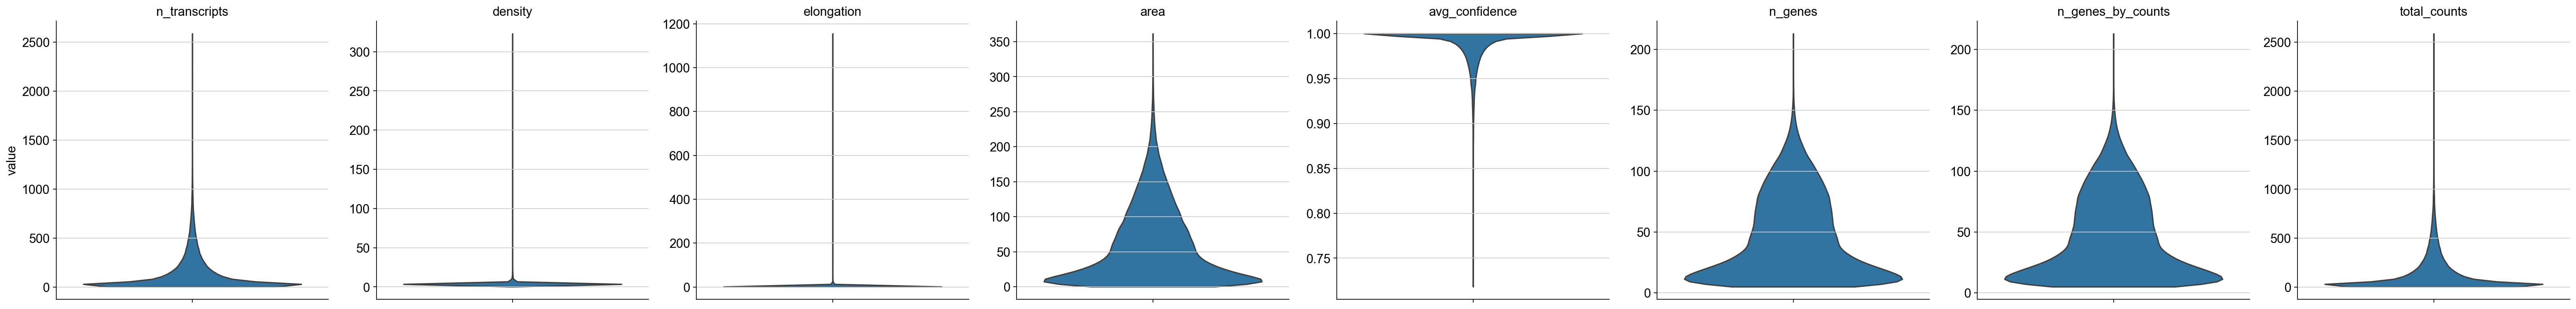

In [9]:
sc.pl.violin(
    adata, 
    ['n_transcripts', 'density', 'elongation', 'area', 'avg_confidence', 'n_genes', 'n_genes_by_counts', 'total_counts'],
    stripplot=False,
    multi_panel=True, 
    save="_genes_counts.png", 
    jitter=0.4
)

To filter the cells, let's use an approach similar to https://rdrr.io/github/LTLA/scuttle/man/perCellQCFilters.html.
For each metric, we try to detect outliers based on the median and MAD deviations as defined in the config.
The scripts creates plots with the upper and lower boundaries and creates a mask that we can then use for subsetting the adata object

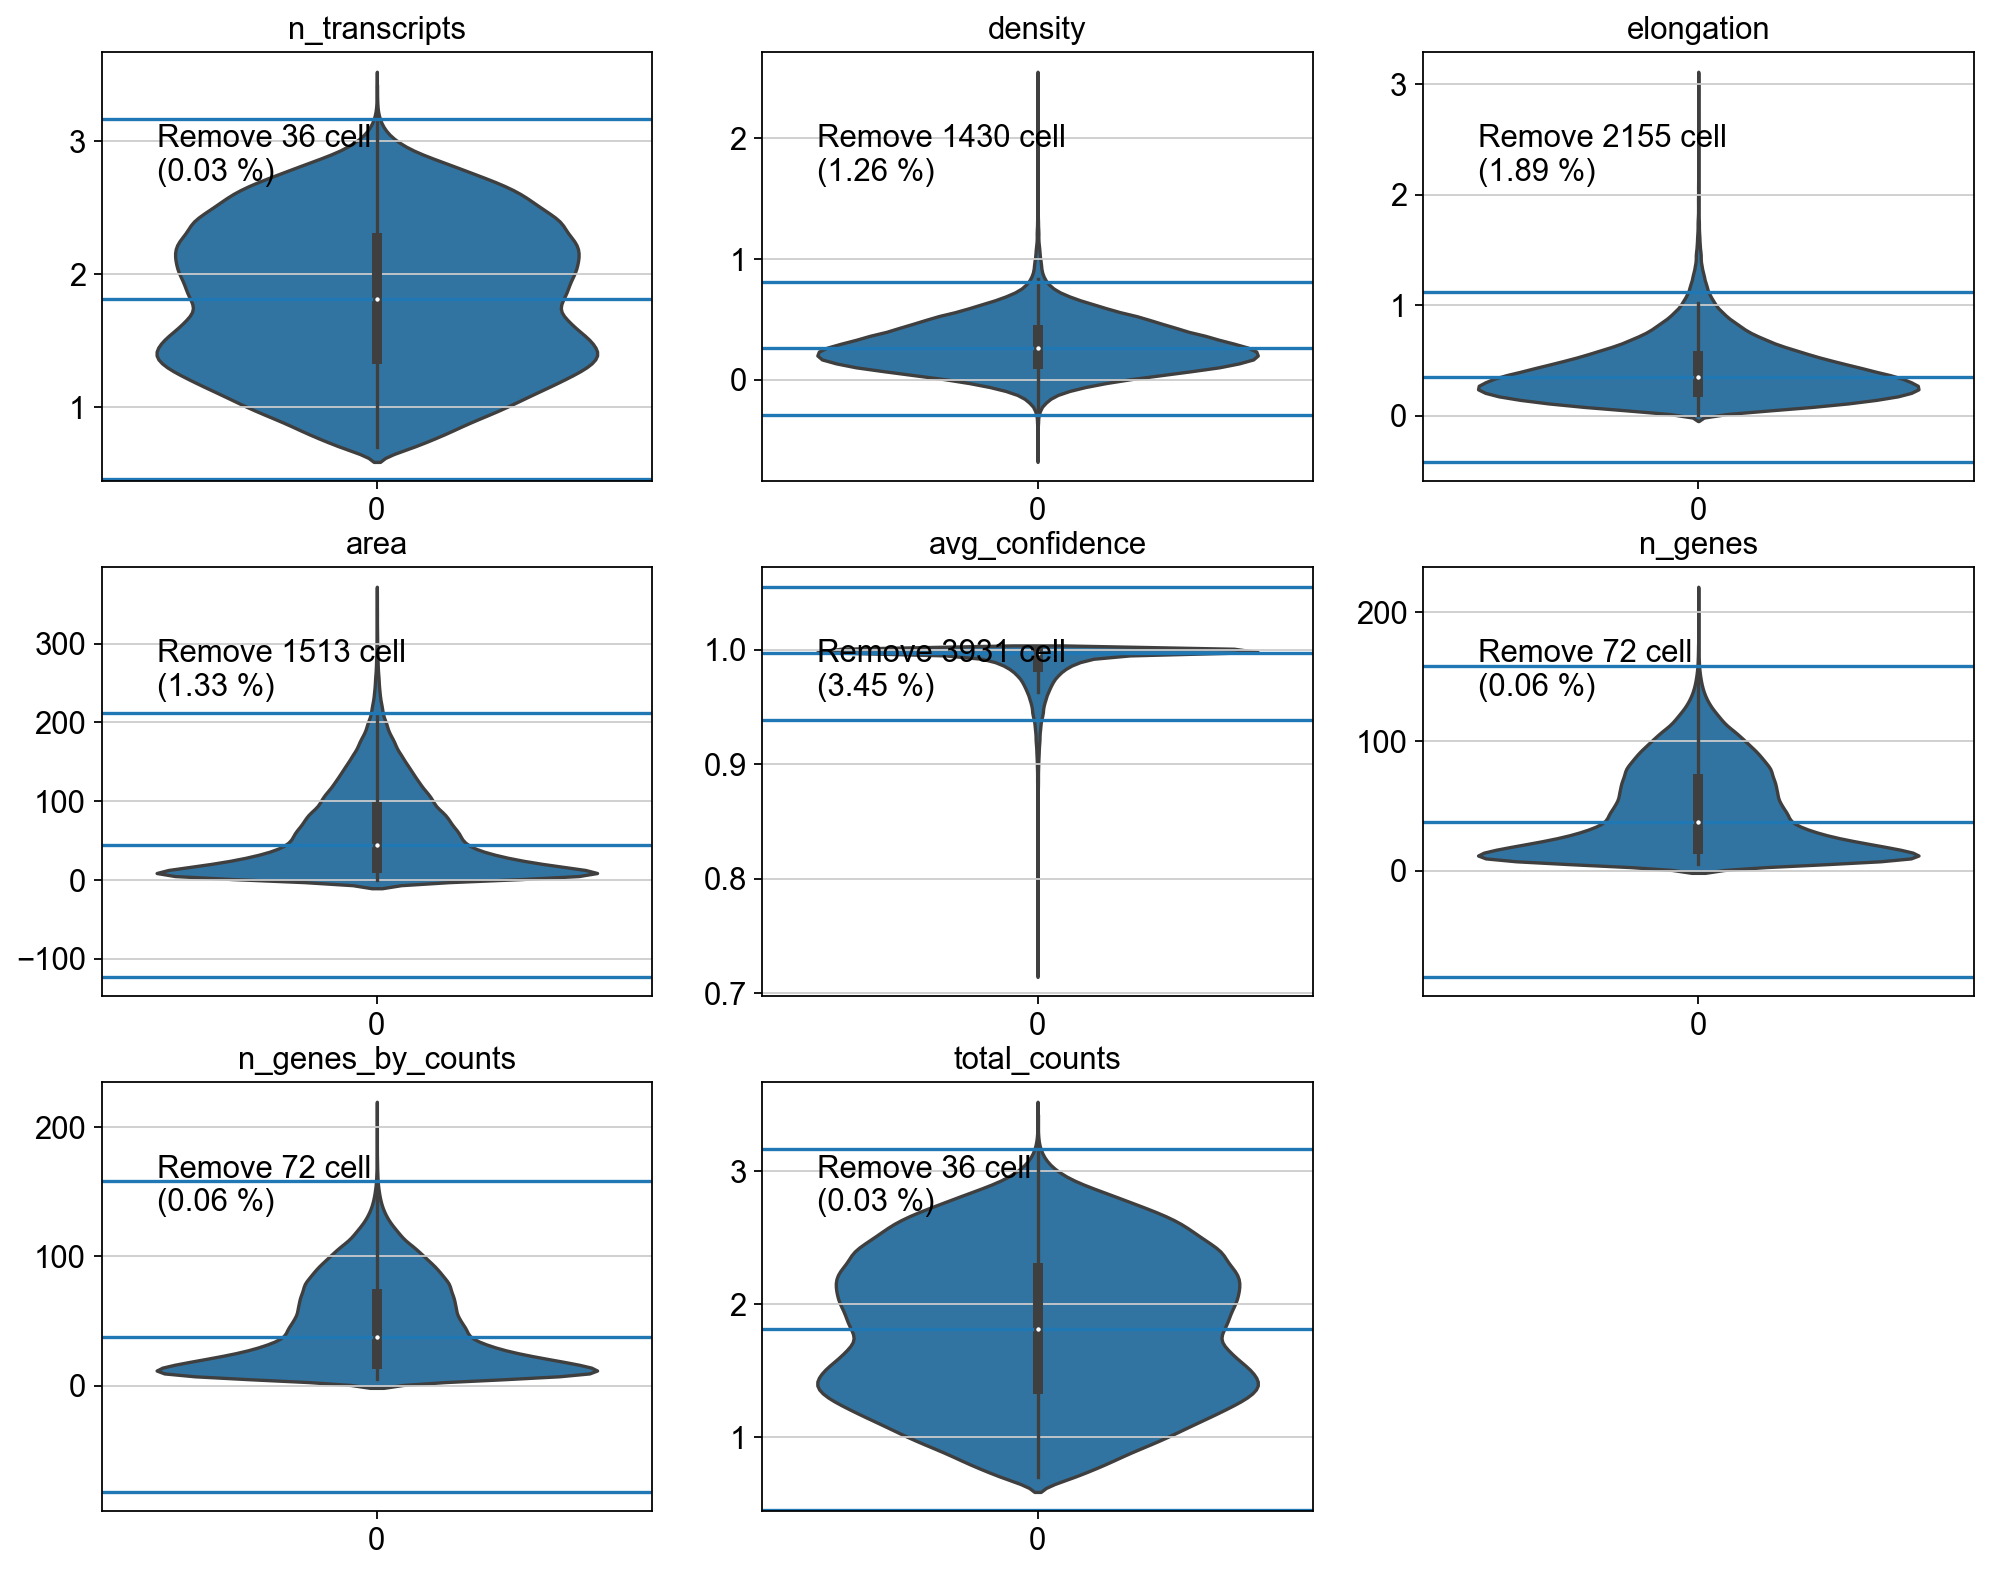

In [10]:
metrics = {
    'n_transcripts' : {
        'n_mad': 3,
        'log': True
    },
    'density' :{
        'n_mad': 4,
        'log': True
    }, 
    'elongation' :{
        'n_mad': 5,
        'log': True
    },
    'area' :{
        'n_mad': 5,
        'log': False
    },
    'avg_confidence' :{
        'n_mad': 20,
        'log': False
    },
    'n_genes' :{
        'n_mad': 5,
        'log': False
    }, 
    'n_genes_by_counts' :{
        'n_mad': 5,
        'log': False
    },
    'total_counts' :{
        'n_mad': 3,
        'log': True
    },
    }
fig = plt.figure(figsize=(15, 12))
summary_discard = []
for i, metric in enumerate(metrics):
    settings = metrics[metric]
    x = np.array(adata.obs[metric])
    if settings['log']: 
        x = np.log10(x)
    median = np.median(x)
    mad = stats.median_abs_deviation(x)
    n_mad = settings['n_mad']
    keep = (x >= median - mad*n_mad) & (x<= median + mad*n_mad)
    summary_discard.append(~keep)
    ax = plt.subplot(3, 3, i + 1)
    sns.violinplot(x, ax=ax)
    ax.set_title(metric)
    ax.axhline(median)
    ax.axhline(median+mad*n_mad)
    ax.axhline(median-mad*n_mad)
    ax.text(x=0.1, y=0.7, s=f"Remove {np.sum(~keep)} cell\n({np.sum(~keep)/len(keep)*100:.2f} %)", transform=ax.transAxes)

In [11]:
summary_discard = np.vstack(summary_discard)
discard = np.sum(summary_discard, axis=0) > 0
np.sum(discard)

8613

So in total, we will get rid of 8613 cells. This seems reasonable

In [12]:
adata = adata[~discard]
adata

View of AnnData object with n_obs × n_vars = 105262 × 499
    obs: 'x', 'y', 'cluster', 'n_transcripts', 'density', 'elongation', 'area', 'avg_confidence', 'cell_shape', 'n_genes', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'points'
    obsm: 'spatial', 'unrolled'

In [13]:
adata.write("anndata_after_qc.h5ad")